In [28]:
from a72_utilities import *
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline


In [29]:
def load_xas_ref_spectra():
    al = pd.read_csv("/Users/apple/Sync/Research/Alloy 72/Reference spectra/al_al2o3_xas_ref_wang.csv")
    ti = pd.read_csv("/Users/apple/Sync/Research/Alloy 72/Reference spectra/ti_tio_tio2_reference_Bzheumikhova.csv")
    ni = pd.read_csv("/Users/apple/Sync/Research/Alloy 72/Reference spectra/Ni_metal_oxide_XAS_ref.csv")
    cr = pd.read_csv("/Users/apple/Sync/Research/Alloy 72/Reference spectra/Cr_metal_oxide_XAS_ref.csv")
    fe = pd.read_csv("/Users/apple/Sync/Research/Alloy 72/Reference spectra/fe_fe2o3_ref_mohamad.csv")
    return {"Cr":cr,"Al":al,"Ni":ni,"Fe":fe,"Ti":ti}

def make_ref_arr(E,I, erange, shift=0):
    merged = pd.DataFrame({"Energy":E,"Intensity":I})
    merged = merged.drop_duplicates(subset=["Energy"])
    merged = merged.dropna()
    merged = merged.sort_values(by=["Energy"])

    spline = CubicSpline(merged["Energy"],merged["Intensity"],bc_type='natural')
    return normalize_array(spline(erange-shift))

In [30]:
xas_elements, xas_masks,xas_energies = load_registered_xas()
xas_refs = load_xas_ref_spectra()

     Cr ref    Cr ref E  Cr2o3 ref  Cr2o3 ref E
0  0.597263  564.999634   0.807022   564.999259
1  0.597188  565.020167   0.806032   565.019049
2  0.597475  565.074160   0.805722   565.072024
3  0.597336  565.125039   0.802732   565.125820
4  0.596734  565.174478   0.802920   565.179177


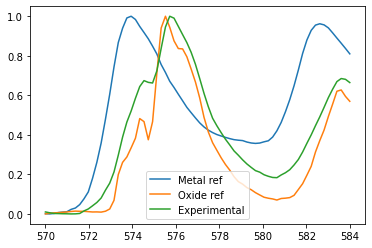

In [31]:
cr = xas_elements['Cr']
eshift = -2
#plt.imshow(cr[5,:,:])
cr_refs = xas_refs["Cr"]
print(cr_refs.head())
cr_metal = make_ref_arr(cr_refs["Cr ref E"],cr_refs["Cr ref"],erange=xas_energies['Cr'],shift = eshift)
cr_oxide = make_ref_arr(cr_refs["Cr2o3 ref E"],cr_refs['Cr2o3 ref'],erange=xas_energies['Cr'], shift = eshift)
plt.plot(xas_energies["Cr"],cr_metal)
plt.plot(xas_energies["Cr"],cr_oxide)
plt.plot(xas_energies["Cr"],normalize_array(np.average(cr,axis=(1,2))))
plt.legend(["Metal ref","Oxide ref","Experimental"])


   TiO2 Energy      TiO2  TiO Energy       TiO   Ti Energy       Ti 
0   451.949820  2.045617  451.726091  1.034432  451.446078  0.030075
1   452.117617  2.045617  451.893888  1.029183  451.983701  0.025156
2   452.285413  2.045617  452.061685  1.031569  452.151703  0.035654
3   452.453210  2.045617  452.229481  1.032523  452.401961  0.040100
4   452.621006  2.045617  452.397278  1.031569  452.655709  0.035654
Index(['TiO2 Energy', 'TiO2', 'TiO Energy', 'TiO', 'Ti Energy', 'Ti '], dtype='object')


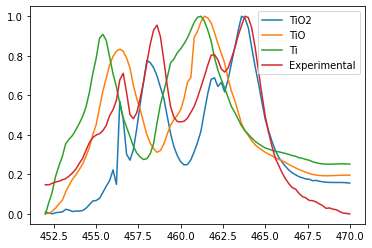

In [45]:
ti = xas_elements['Ti']
eshift = -1.8 
#plt.imshow(cr[5,:,:])
ti_refs = xas_refs["Ti"]
print(ti_refs.head())
print(ti_refs.keys())
tio2 = make_ref_arr(ti_refs["TiO2 Energy"],ti_refs["TiO2"],erange=xas_energies['Ti'],shift = eshift)
tio = make_ref_arr(ti_refs["TiO Energy"],ti_refs['TiO'],erange=xas_energies['Ti'], shift = eshift)
ti_metal = make_ref_arr(ti_refs["Ti Energy"],ti_refs["Ti "],erange = xas_energies["Ti"],shift = eshift)
plt.plot(xas_energies["Ti"],tio2)
plt.plot(xas_energies["Ti"],tio)
plt.plot(xas_energies['Ti'],ti_metal)
plt.plot(xas_energies["Ti"],normalize_array(np.average(ti,axis=(1,2))))
plt.legend(["TiO2","TiO","Ti","Experimental"])

      Fe2O3 E     Fe2O3        Fe E        Fe
0  702.977469  0.292504  702.816058  0.249288
1  705.936683  0.291304  703.192685  0.249288
2  706.582330  0.339323  704.214959  0.263693
3  707.156238  0.411351  704.860606  0.263693
4  707.658408  0.504987  705.506252  0.278099


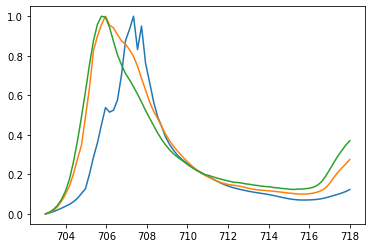

In [44]:
fe_refs = xas_refs["Fe"]
fe_shift = -3.1
print(fe_refs.head())
fe_metal = make_ref_arr(fe_refs["Fe E"],fe_refs["Fe"],erange=xas_energies["Fe"],shift=fe_shift)
fe2o3 = make_ref_arr(fe_refs["Fe2O3 E"], fe_refs["Fe2O3"],erange=xas_energies["Fe"],shift=fe_shift)

plt.plot(xas_energies["Fe"],fe2o3)
plt.plot(xas_energies["Fe"],fe_metal)
plt.plot(xas_energies["Fe"],normalize_array(np.average(xas_elements["Fe"],axis=(1,2))))

In [ ]:
plt.plot()